In [1]:
import numpy as np 
import cv2
import os
#The shutil module offers a number of high-level operations on files and collections of files
import shutil
import itertools
from sklearn.utils import shuffle
# series of convenience functions to make basic image processing functions such as translation, rotation, resizing, skeletonization, displaying Matplotlib images,a collection of convenience functions for working with images in OpenCV.
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# python library for making quality graph
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [7]:
#  this codes divides the dataset into training, validation, and test sets, with 80% of the images used for training, 10% for validation, and the remaining 10% for testing.
# path of brain_tumor dataset
IMG_PATH = 'brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    # calculates the total no. of images in the current class directory
    IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
    #This loop iterates over each image file in the current class directory while keeping track of the index n and the filename FILE_NAME.
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
        img = IMG_PATH + CLASS + '/' + FILE_NAME
        if n < 5:
            shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
        elif n < 0.8*IMG_NUM:
            shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
        else:
            shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

### Data Import and Preprocessing

In [37]:
# By associating images with their corresponding labels (in this case, the presence or absence of a brain tumor), you provide the model with ground truth information during training, 
# enabling it to learn the relationship between the input data (images) and the output labels. This allows the model to make predictions on new, unseen data.
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = [] # List to store images
    y = [] # List to store labels
    for yesorno in (sorted(os.listdir(dir_path))): # Loop over classes ('YES' or 'NO')
        for imgname in os.listdir(dir_path + yesorno): # Loop over images in each class directory
            img = cv2.imread(dir_path + yesorno + '/' + imgname) # Read image using OpenCV
            img = cv2.resize(img, img_size)  # Resize image to img_size
            X.append(img)
            if yesorno=='NO':
                y.append(0) # Append label 0 for 'NO' class
            else:
                y.append(1)  # Append label 1 for 'YES' class
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y # Return loaded images and labels as numpy arrays



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val = load_data(VAL_DIR, IMG_SIZE)

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [10]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Let's take a look at the distribution of classes among sets:

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

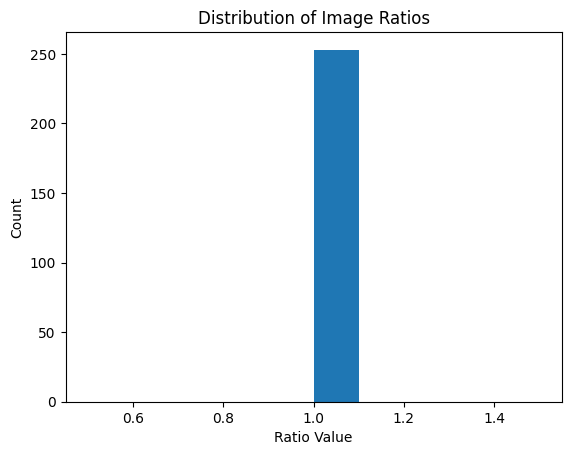

In [11]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [19]:
#image processing
def crop_imgs(set_name, add_pixels_value=0, target_size=(224, 224), interpolation=cv2.INTER_CUBIC):

    set_new = []
    for img in set_name:
        # Perform cropping
        cropped_img = crop_image(img, add_pixels_value)
        
        # Resize the cropped image to the target size with the specified interpolation method
        resized_img = cv2.resize(cropped_img, dsize=target_size, interpolation=interpolation)
        
        # Append the resized image to set_new
        set_new.append(resized_img)
    
    return np.array(set_new)
    
def crop_image(img, add_pixels_value=0):
    #The parameter add_pixels_value is used to add extra pixels around the cropped region. By default, it's set to 0.
    
    #Converts the input image (img) to grayscale using OpenCV's cvtColor function.
    #1.By converting the image to grayscale, you reduce the complexity of the data from three color channels (RGB) to a single channel (intensity). 
    #This simplification can make subsequent image processing operations, such as thresholding or contour detection, more straightforward and computationally efficient.
    #2.Grayscale images typically have less noise than color images. This is because the noise in color images can be present in multiple channels, whereas in grayscale images, it's confined to a single channel. 
    #Applying operations like Gaussian blur to grayscale images can further reduce noise, which is beneficial for subsequent processing steps.

    # here converting the image to grayscale before performing thresholding and contour detection operations helps isolate the main features of interest (e.g., tumors in medical images) from the background and other artifacts. 
    # This simplifies the process of identifying the region of interest and cropping the image accordingly.
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

        
    # Applying a binary thresholding operation to the blurred image, creating a binary image where pixels above a certain threshold are set to 255 (white) and pixels below the threshold are set to 0 (black) , by doing so we can isolate the region of interest from the rest of the image,can reduce the impact of noise in the image,contour detection algorithms can be applied more effectively,finding the extreme points or cropping the image.
    #then perform a series of erosions + dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        
    #Performs erosion on the binary image to remove small regions of noise.
    thresh = cv2.erode(thresh, None, iterations=2)
        
    #Performs dilation on the eroded image to restore the areas of interest.
    thresh = cv2.dilate(thresh, None, iterations=2)
    #performing erosion followed by dilation, the overall effect is known as opening, which is a morphological operation used to remove small objects and smooth the boundaries of larger objects in binary images,Opening is particularly useful for preprocessing images before further analysis, such as contour detection or object segmentation.


        
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Extracts contours from the result returned by findContours.
    cnts = imutils.grab_contours(cnts)
    #Finds the contour with the maximum area.
    # we uses  max function with a custom key function cv2.contourArea, which calculates the area of each contour.the max function compares contours based on their areas.The contour with the maximum area represents the largest object or region in the image, which is typically the object of interest 
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points, these extreme points are used to define the boundaries of the region of interest before cropping the image.
    extLeft = tuple(c[c[:, :, 0].argmin()][0]) #c[:, :, 0] extracts the x-coordinates of all points in the contour,argmin() returns the index of the minimum x-coordinate, which corresponds to the leftmost point,c[c[:, :, 0].argmin()] selects the point in the contour with the minimum x-coordinate,tuple() converts the point to a tuple.
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    #Crops the original image (img) using the coordinates of the extreme points and the additional pixels.
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        

    return new_img

Let's look at example what this function will do with MRI scans:

In [16]:
#The parameter interpolation specifies the interpolation method to be used during resizing. In this case, cv2.INTER_CUBIC is used, which is a high-quality interpolation method suitable for enlarging images.
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
#The contour is drawn in yellow color (0, 255, 255) with a thickness of 4 pixels.
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
#Draws a red circle at the leftmost point (extLeft) on the contour.
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
#Draws a green circle at the rightmost point (extRight) on the contour.
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
#Draws a blue circle at the topmost point (extTop) on the contour.
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
#Draws a cyan circle at the bottommost point (extBot) on the contour.
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
#This line crops the original image (img) based on the extreme points (extLeft, extRight, extTop, extBot) and the specified number of additional pixels (ADD_PIXELS).
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

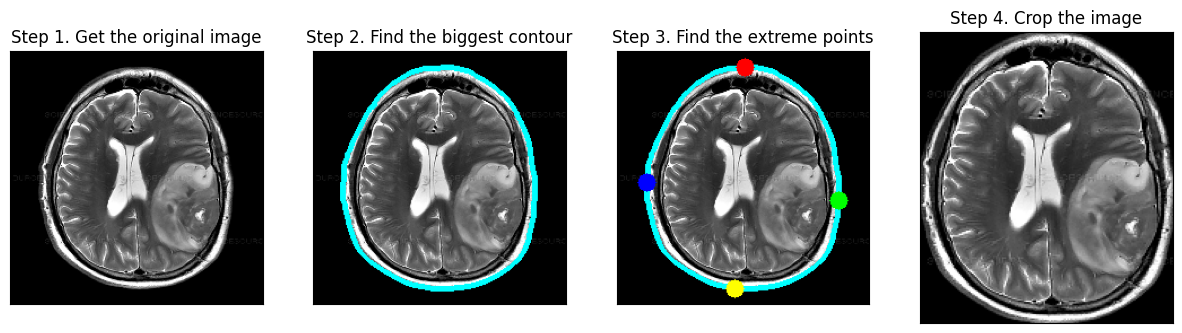

In [17]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [20]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

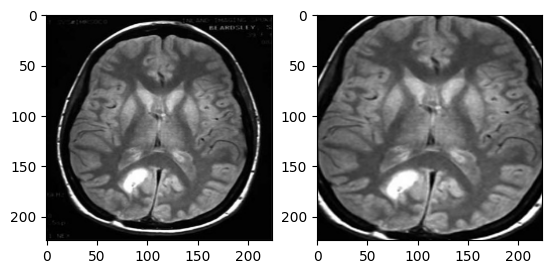

In [21]:
i = 100

plt.subplot(121)
plt.imshow(X_train[i])

plt.subplot(122)
plt.imshow(X_train_crop[i])

In [22]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    #this loop iterates over each image (img) along with its corresponding label (imclass) using the zip function, which pairs elements of x_set and y_set together.
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [23]:
# saving new images to the folder

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [24]:
print(len(os.listdir('TEST_CROP/YES')))
print(len(os.listdir('TEST_CROP/NO')))
print(len(os.listdir('TRAIN_CROP/YES')))
print(len(os.listdir('TRAIN_CROP/NO')))
print(len(os.listdir('VAL_CROP/YES')))
print(len(os.listdir('VAL_CROP/NO')))

5
5
119
74
31
19


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [25]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [26]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

#Shuffling the data helps to remove any inherent bias in the dataset and ensures that the model sees a diverse range of samples during training.
#The random_state parameter is set to 0 to ensure reproducibility of the shuffling process,the shuffling operation will produce the same shuffled order every time the code is run with the same dataset. This ensures that the model training process starts from the same initial conditions, allowing for reproducibility of results.
X_train_prep,y_train = shuffle(X_train_prep,y_train,random_state=0)
X_test_prep,y_test = shuffle(X_test_prep,y_test,random_state=0)
X_val_prep,y_val = shuffle(X_val_prep,y_val,random_state=0)

In [27]:
y_train

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1])

In [28]:
# set the paramters we want to change randomly
#sets up an ImageDataGenerator object named demo_datagen with various parameters for data augmentation
# Data augmenttaion is artificially increase the size and diversity of a dataset by applying various transformations to the existing data samples.. These transformations create new versions of the original data instances while preserving their underlying characteristics.
demo_datagen = ImageDataGenerator(
    rotation_range=15,#Specifies the range within which to randomly rotate the images during augmentation
    width_shift_range=0.05,#These parameters specify the ranges within which to randomly shift the width and height dimensions of the images, respectively.
    height_shift_range=0.05,
    rescale=1./255, #Scales the pixel values of the images. In here, each pixel value is divided by 255 to rescale them to the range [0, 1].
    shear_range=0.05,#Specifies the range for randomly applying shear transformations to the images. Shear transformations slant the shape of the images along the horizontal or vertical axis.
    brightness_range=[0.1, 1.5],# Specifies the range for randomly adjusting the brightness of the images. Images' brightness can be randomly adjusted within the range [0.1, 1.5]. A value of 1.0 means no change, less than 1.0 means darker, and greater than 1.0 means brighter.
    horizontal_flip=True, #These parameters determine whether to randomly flip the images horizontally and vertically, respectively. Both are set to True, indicating that images can be flipped randomly along both axes.
    vertical_flip=True
)

In [29]:
#visualize data augmentation by applying transformations to a single image from the training set (X_train_crop[0]) and generating multiple augmented versions of it.
x = X_train_crop[0]  
#The image x is reshaped to have an additional dimension at the beginning to represent the batch size. This is necessary for compatibility with the ImageDataGenerator which expects input data in the form of batches.
x = x.reshape((1,) + x.shape) 

i = 0
#The batch_size parameter is set to 1, indicating that each iteration of the loop generates one augmented image.
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

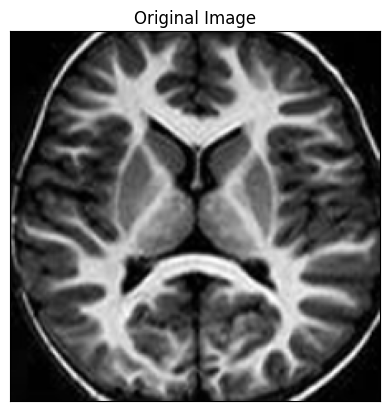

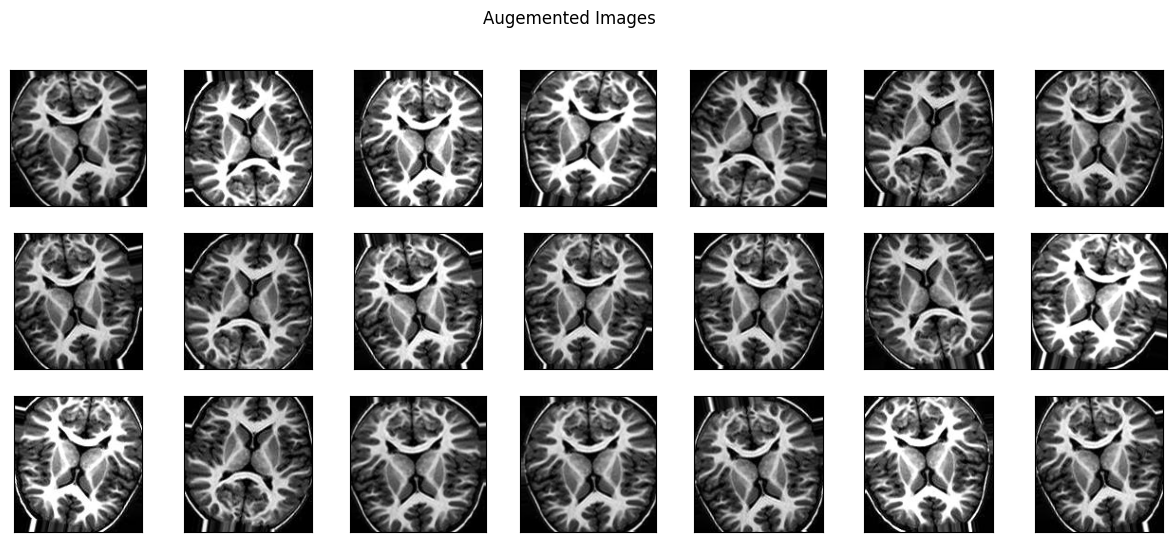

In [30]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [31]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

#Setting up an ImageDataGenerator for augmenting training data.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    #The preprocessing_function parameter in the ImageDataGenerator of Keras allows you to apply additional preprocessing to the images before they are fed into the model for training or inference
    #Here we have used the preprocess_input function, which is often used with pre-trained models to ensure compatibility with their expected input format.
    # the preprocess_input function serves to prepare the input data in a way that is consistent with the requirements of the pre-trained model being used. By applying this preprocessing function to the images before training or inference, you ensure that the input data is compatible with the model and that it receives the necessary preprocessing to achieve optimal performance.
    preprocessing_function=preprocess_input
)

#test_datagen configured with the preprocess_input function as the preprocessing_function. This means that the same preprocessing applied to the training images will also be applied to the validation images.
# Note: It's common practice to preprocess both training and validation images in the same way to ensure consistency and fairness during model evaluation.
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

#train_generator is created using train_datagen.flow_from_directory, which generates batches of augmented training data from the specified directory (TRAIN_DIR).
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary'
)

#validation_generator is created using test_datagen.flow_from_directory, which generates batches of validation data from the specified directory (VAL_DIR)
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [32]:
train_generator.samples

193

### Model Building

In [33]:
# load base model
#VGG16 model without the top (fully connected) layers using pre-trained weights. 
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, #Indicates that the fully connected layers (top layers) of the VGG16 model should not be included. This is useful when you want to use the VGG16 model as a feature extractor 
    input_shape=IMG_SIZE + (3,) # IMG_SIZE represents the desired input image dimensions, and (3,) indicates that the input should have three channels corresponding to the RGB color channels.
)

In [35]:
#Initializes a Sequential model, which allows you to build a neural network by stacking layers sequentially.
model = Sequential()
model.add(base_model)#Adds the VGG16 base model to the Sequential model. This includes the convolutional layers of VGG16 that have been loaded without the top layers.
model.add(layers.Flatten())#Adds a Flatten layer to the model. This layer flattens the output of the previous convolutional layers into a 1D array, which can then be fed into the fully connected layers.
model.add(layers.Dropout(0.5))#Adds a Dropout layer with a dropout rate of 0.5. Dropout is a regularization technique that randomly sets a fraction of input units to zero during training, which helps prevent overfitting by reducing the reliance on any specific feature.
model.add(layers.Dense(1, activation='sigmoid'))#Adds a Dense layer with a single neuron and sigmoid activation function. This layer serves as the output layer for binary classification tasks, where the model predicts the probability of the positive class.

model.layers[0].trainable = False#Freezes the weights of the VGG16 base model to prevent them from being updated during training. This is done to retain the pre-trained features learned by VGG16 and prevent overfitting on the limited training data.

#Model Compilation
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [36]:
#Configures early stopping, which monitors the validation accuracy (val_accuracy) and stops training if the accuracy doesn't improve for a certain number of epochs (patience).
# Here, it stops training if there's no improvement for 6 consecutive epochs.
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch = 193,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[es],
)
model.save('../models/braintumor.h5')

Epoch 1/30
193/193 [==============================] - 91s 453ms/step - loss: 5.5051 - accuracy: 0.5233 - val_loss: 5.0309 - val_accuracy: 0.5800
Epoch 2/30
193/193 [==============================] - 87s 449ms/step - loss: 3.2525 - accuracy: 0.6839 - val_loss: 1.8996 - val_accuracy: 0.7000
Epoch 3/30
193/193 [==============================] - 88s 456ms/step - loss: 3.3691 - accuracy: 0.6580 - val_loss: 1.3350 - val_accuracy: 0.7200
Epoch 4/30
193/193 [==============================] - 87s 451ms/step - loss: 2.4987 - accuracy: 0.7098 - val_loss: 1.0609 - val_accuracy: 0.8000
Epoch 5/30
193/193 [==============================] - 86s 447ms/step - loss: 3.1761 - accuracy: 0.6943 - val_loss: 0.6585 - val_accuracy: 0.8400
Epoch 6/30
193/193 [==============================] - 87s 449ms/step - loss: 2.7472 - accuracy: 0.7565 - val_loss: 0.7445 - val_accuracy: 0.8200
Epoch 7/30
193/193 [==============================] - 87s 450ms/step - loss: 2.6636 - accuracy: 0.6995 - val_loss: 0.6442 - val_ac

C:\Users\welcome\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



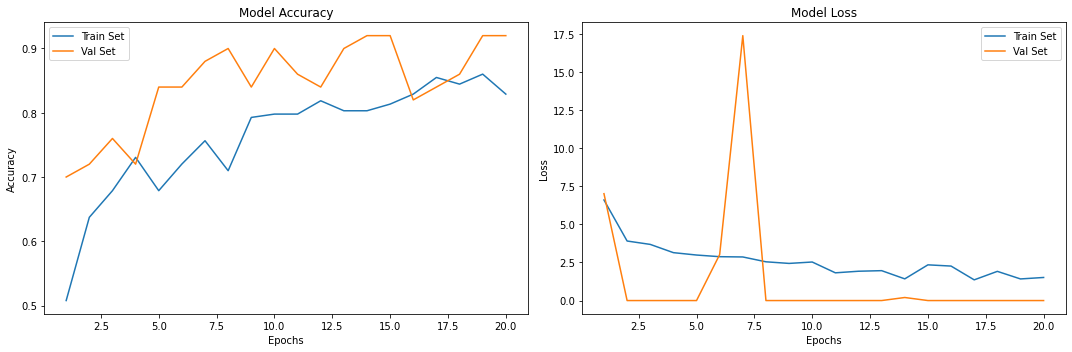

In [27]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.88


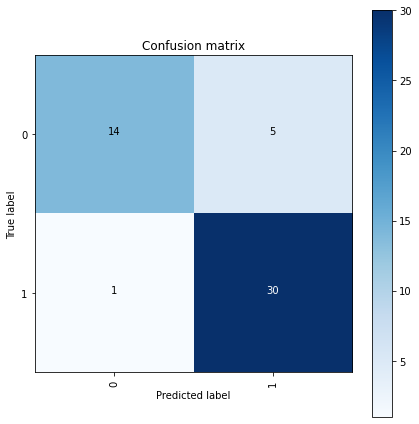

In [28]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = [0,1], normalize=False)

Test Accuracy = 1.00


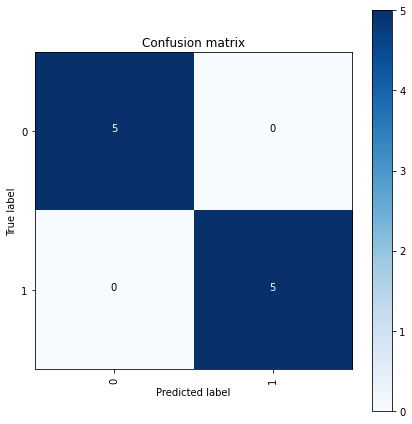

In [29]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = [0,1], normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

In [30]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

There are no missclassified images.


# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning:

Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No Tumor


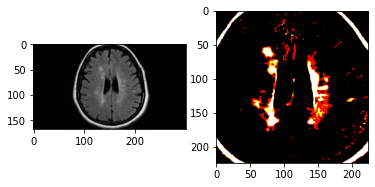

In [31]:
IMG_SIZE = (224,224)

# live test

model = load_model('braintumor.h5')
testimgpath = 'brain_tumor_dataset/no/42 no.jpg'

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img,dsize=img_size,interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)



def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


#read
plt.subplot(121)
test_img = cv2.imread(testimgpath)
plt.imshow(test_img)

#resize
# plt.subplot(132)
# test_img = cv2.resize(test_img,dsize=IMG_SIZE,interpolation=cv2.INTER_CUBIC)
# plt.imshow(test_img)

#crop and resize and preprocess for vgg
plt.subplot(122)
test_img = crop_imgs([test_img])
test_img = test_img.reshape(test_img.shape[1:])
test_img = preprocess_imgs([test_img],IMG_SIZE)
plt.imshow(test_img.reshape(test_img.shape[1:]))

#make prediction
pred = model.predict(test_img)
if pred<0.5:
    print('No Tumor')
else:
    print('Brain is having the tumor')